# <center>Проект-3. Использование EDA для предсказания рейтинга отелей.</center>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import category_encoders as ce
import nltk
import warnings
import plotly.io as pio
from sklearn import preprocessing
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [2]:
warnings.filterwarnings('ignore')
nltk.downloader.download('vader_lexicon')
pio.renderers.default = 'png'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sadeyes\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
hotels_train = pd.read_csv('data/hotels.csv')
hotels_test = pd.read_csv('data/hotels_test.csv')
sample_submission = pd.read_csv('data/submission.csv')

In [4]:
hotels_train['sample'] = 1
hotels_test['sample'] = 0
hotels_test['reviewer_score'] = 0

In [5]:
hotels = hotels_test.append(hotels_train, sort=False).reset_index(drop=True)
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0


* hotel_address — адрес отеля;
* review_date — дата, когда рецензент разместил соответствующий отзыв;
* average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
* hotel_name — название отеля;
* reviewer_nationality — страна рецензента;
* negative_review — отрицательный отзыв, который рецензент дал отелю;
* review_total_negative_word_counts — общее количество слов в отрицательном отзыве;
* positive_review — положительный отзыв, который рецензент дал отелю;
* review_total_positive_word_counts — общее количество слов в положительном отзыве.
* reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
* total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
* total_number_of_reviews — общее количество действительных отзывов об отеле;
* tags — теги, которые рецензент дал отелю;
* days_since_review — количество дней между датой проверки и датой создания датасета;
* additional_number_of_scoring — количество оценок без отзыва;
* lat — географическая широта отеля;
* lng — географическая долгота отеля.

***

## Мысли о каждом признаке и дальнейшей работе с ними.

### hotel_address

Каждый адрес состоит из примерно следующего шаблона - "название улицы, номер дома, уточненяющие детали(номер квартиры или район города), почтовый индекс города, название города, страна".

Что мы можем получить из этого признака:
* новый признак *страна отеля*
* город отеля
* столицу страны
* координаты города отеля и координаты столицы с помощью библиотек
* посчитать расстояние между этими координатами и получить новый признак *расстояние от отеля до столицы*, отсюда же можно выделить ещё один признак - *является ли город отеля столицей (например, если расстояние до центра столицы не более 50 км)*

### review_date

Дата с точностью до дня. Можно попробовать создать 4 признака сезонности(с помощью OneHotEncoder): зима, весна, лето, осень. Возможно, в какие-то времена года рецензенты ставят более высокие оценки, чем в другие.

### average_score

Не уверен, что из данного признака можно получить ещё больше информации, чем он уже даёт.

### hotel_name

Уникальные названия отелей. Если их не слишком много в датасете, тогда имеет смысл закодировать их с помощью OneHotEncoder или BinaryEncoder. 

### reviewer_nationality

Из какой страны рецензент прибыл в отель. Можно поступить следующим образом - найти в интернете некоторый коэффициент уровня жизни в конкретной стране. Сопоставить этот коэффициент с коэффициентом той страны, в отель которой заселился рецензент. Если в стране, откуда прибыл рецензент, коэффициент уровня жизни больше, чем в стране отеля, то есть вероятность, что человек останется менее доволен сервисом и обслуживанием, как следствие - выше риск, что человек оставит негативный отзыв. То же самое и в обратную сторону.

### negative_review & positive_review

Отзывы можно проанализировать с помощью сторонней библиотеки на соотношение положительных, отрицательных и нейтральных слов.

### review_total_negative_word_counts & review_total_positive_word_counts

Чем больше слов в одной из категорий отзывов - тем выше шанс, что человек склоняется к тому варианту, где он больше написал. Если много слов в отрицательном отзыве и мало в положительным - почти очевидно, что будет поставлена низкая оценка.

### reviewer_score

Целевая переменная, которую необходимо предсказать. 

### total_number_of_reviews_reviewer_has_given

Признак, оценивающий надёжность ревьювера. Если он дал много отзывов в прошлом, значит с большей долей вероятности можно считать, что отзыв был объективен. Можно попробовать создать признак, показывающий эту самую надёжность в бинарном представлении (0 - меньше 5 отзывов, 1 - больше 5 отзывов).

### total_number_of_reviews

Признак надёжности отеля. Если отзывов много, то средний рейтинг можно считать объективным. Если отзывов мало - нельзя, т.к. такой отзыв мог оставить, например, конкурент из отельного бизнеса, чтобы помешать развитию.

### tags

Необходимы дополнительные исследования данного признака, чтобы понять, какие данные и в каком представлении мы можем получить отсюда.

### days_since_review

Вероятно, данный признак имеет небольшой вес и его не стоит удалять, хотя и кажется, что пользы не несёт. Например, если прошло уже достаточно много дней с момента последнего отзыва, значит, что этот отзыв был, скорее всего, негативным, и отель больше не привлекает новых посетителей. Если нет новых посетителей - отель либо закрывается, либо уменьшаются затраты на его содержание, что напрямую влияет на итоговый рейтинг. 

### additional_number_of_scoring

Можно создать признак *количество оценок, имеющих отзыв*. Для этого вычтем из *total_number_of_reviews* признак *additional_number_of_scoring* и получим необходимое значение.

### lat & lng

Широту и долготу будем использовать для расчета расстояния между городом отеля и столицей страны.

***

## Предварительный анализ датасета.

In [6]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Пропущенные значения в признаках.

In [7]:
hotels.isnull().sum().sort_values(ascending=False)

lng                                           3268
lat                                           3268
hotel_address                                    0
additional_number_of_scoring                     0
sample                                           0
days_since_review                                0
tags                                             0
total_number_of_reviews_reviewer_has_given       0
review_total_positive_word_counts                0
positive_review                                  0
total_number_of_reviews                          0
review_total_negative_word_counts                0
negative_review                                  0
reviewer_nationality                             0
hotel_name                                       0
average_score                                    0
review_date                                      0
reviewer_score                                   0
dtype: int64

Количество дубликатов. Удалим их на этапе построения модели из train data, таким образом размерность test data останется такой же, как и у submission, но модель будет обучаться на данных без дубликатов.

In [8]:
hotels[hotels.duplicated()].shape[0]

336

***

## Добавим признак страны отеля и информацию о населении в стране каждого отеля

Посмотрим на пример строк из признака hotel_address, чтобы выделить оттуда важную информацию и увидеть структуру строк.

In [9]:
for i in range(0, 10, 2):
    display(hotels['hotel_address'].iloc[i])

'Via Senigallia 6 20161 Milan Italy'

'Mallorca 251 Eixample 08008 Barcelona Spain'

'Singel 303 309 Amsterdam City Center 1012 WJ Amsterdam Netherlands'

'Empire Way Wembley Brent London HA9 8DS United Kingdom'

'35 Rue Caumartin 9th arr 75009 Paris France'

Возьмем таблицу с Википедии о названии и населении(в миллионах) всех стран.

In [10]:
countries_info = pd.read_html('https://en.wikipedia.org/wiki/List_of_countries_and_dependencies_by_population')[1]
total_population = countries_info['Population']['Numbers'].iloc[0]
countries_info['% of the world'] = (countries_info['Population']['Numbers'] / 1e6).round(2)
countries_info = countries_info.sort_index(axis=1).drop(
    columns=['Date', 'Notes', 'Source (official or from the\xa0United Nations)', 'Rank', 'Population'],
    index=0).droplevel(level=1, axis=1).rename(
    columns={'% of the world': 'population',
             'Country / Dependency': 'country'}).sort_index(axis=1)
countries_info.head()

,country,population
1,China,1411.75
2,India,1375.59
3,United States,334.40
4,Indonesia,275.77
5,Pakistan,235.82


Создадим признак *country*, в котором будет информация о стране, в которой располагается отель.

In [11]:
def get_country(address:str) -> str:
    
    """Returns existing country for raw address. If the country was not found, then returns none 

    Args:
        address (str): Raw address

    Returns:
        str: One of the existing countries
    """
    
    for country in countries_info['country'].to_list():
        if country in ' '.join(address.split()[-2:]):
            return country

hotels['country'] = hotels['hotel_address'].apply(get_country)
hotels = hotels.join(countries_info.set_index('country'), on='country')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,population
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,58.89
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,17.80
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0,Spain,47.62


Убедимся, что мы заполнили поле страны для каждого отеля.

In [12]:
hotels['country'].isnull().sum()

0

***

## Анализ каждого числового признака из оригинального датасета.

Выделим все числовые признаки в отдельный датафрейм, чтобы было удобнее их анализировать.

In [13]:
num_features = hotels[[col for col in hotels.columns if hotels[col].dtype != 'object']].drop(columns=['lat', 'lng'])
num_features.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,sample,reviewer_score,population
0,904,8.1,52,16670,62,1,0,0.0,58.89
1,612,8.6,10,5018,0,7,0,0.0,17.80
2,46,8.3,3,351,5,15,0,0.0,47.62
3,241,9.1,0,1543,27,9,0,0.0,58.89
4,834,9.1,0,4687,7,2,0,0.0,17.80


Будем изучать каждый признак с помощью соответствующих графиков и пояснений к нему.

### *additional_number_of_scoring*

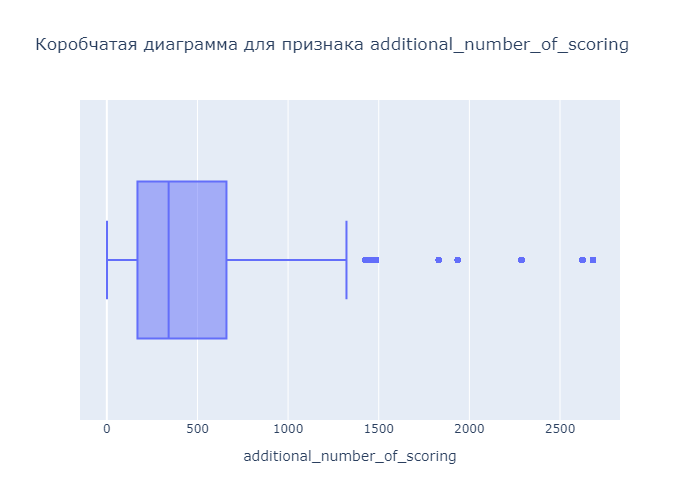

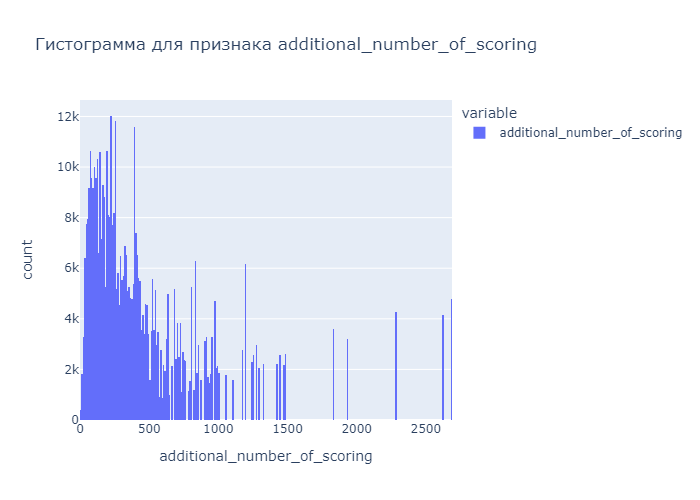

In [14]:
additional_scoring_box = px.box(
    x=num_features['additional_number_of_scoring'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака additional_number_of_scoring',
    labels={'x': 'additional_number_of_scoring'}
)
additional_scoring_hist = px.histogram(
    num_features['additional_number_of_scoring'],
    height=500,
    width=700,
    title='Гистограмма для признака additional_number_of_scoring',
    labels={'value': 'additional_number_of_scoring'}
)
additional_scoring_box.show()
additional_scoring_hist.show()

По коробчатой диаграмме можно подумать, что тут есть аномальные значения(выбросы), которые необходимо удалить, но гистограмма говорит об обратном - значения признака выше 1500 встречаются не так уж редко, чтобы называть их выбросами.

### *average_score*

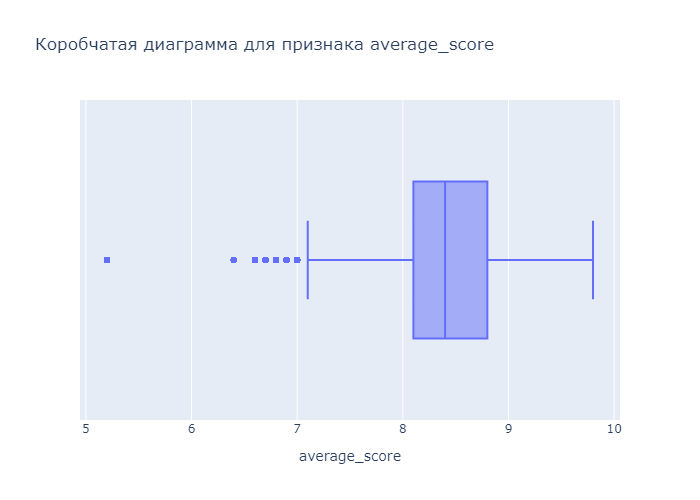

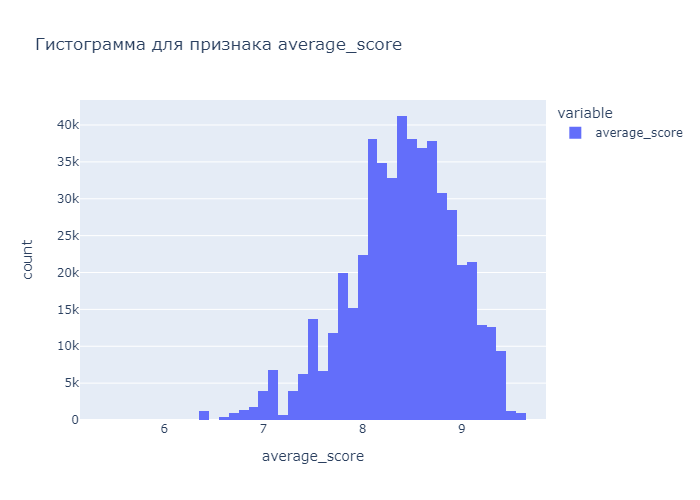

In [15]:
average_score_box = px.box(
    x=num_features['average_score'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака average_score',
    labels={'x': 'average_score'}
)
average_score_hist = px.histogram(
    num_features['average_score'],
    height=500,
    width=700,
    title='Гистограмма для признака average_score',
    labels={'value': 'average_score'}
)
average_score_box.show()
average_score_hist.show()

*average_score* тоже не нуждается в очистке, большинство данных распределено нормально, аномальные значения не наблюдаются.

### *review_total_negative_word_counts*

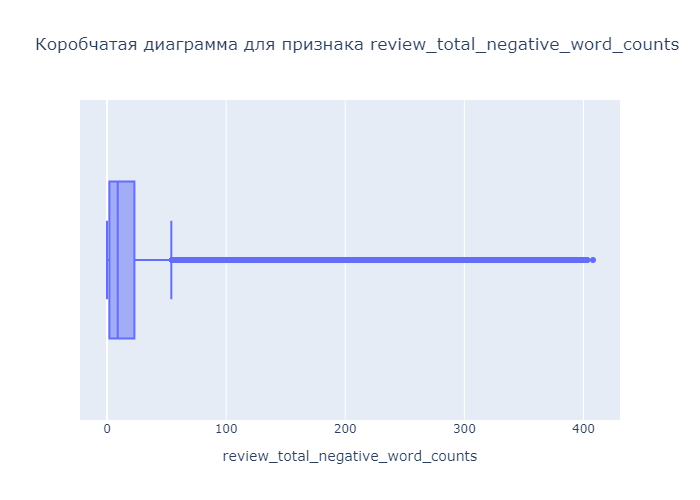

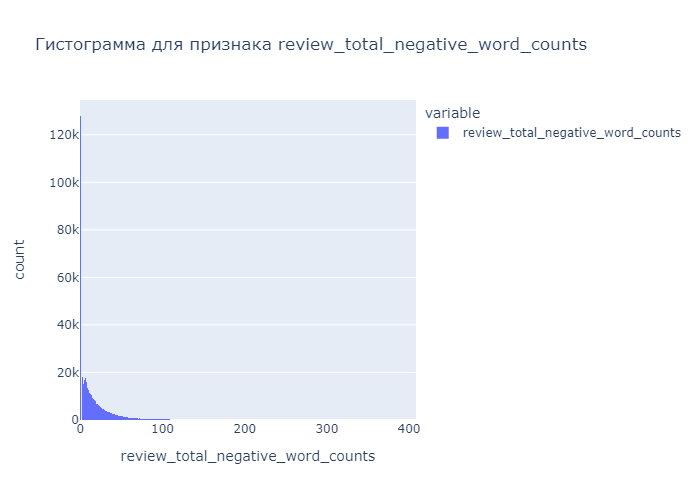

In [16]:
total_negative_box = px.box(
    x=num_features['review_total_negative_word_counts'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака review_total_negative_word_counts',
    labels={'x': 'review_total_negative_word_counts'}
)
total_negative_hist = px.histogram(
    num_features['review_total_negative_word_counts'],
    height=500,
    width=700,
    title='Гистограмма для признака review_total_negative_word_counts',
    labels={'value': 'review_total_negative_word_counts'}
)
total_negative_box.show()
total_negative_hist.show()

In [17]:
# Посмотрим, сколько записей имеют более 100 негативных слов в отзыве
num_features[num_features['review_total_negative_word_counts'] > 100].shape[0]

11637

Данный признак имеет логнормальное распределение. Чаще всего количество негативных слов = 0. Думаю, этот признак довольно важен, т.к. может напрямую влиять на целевую переменную рейтинга. Больше негативных слов -> хуже рейтинг. И наоборот. Оставим в таком виде

### *total_number_of_reviews*

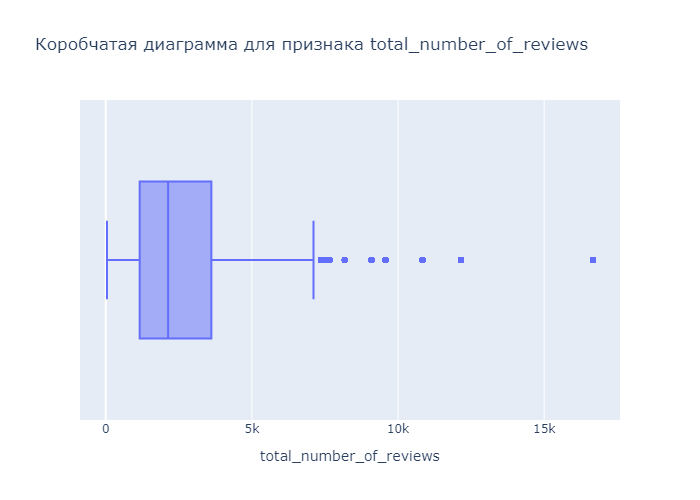

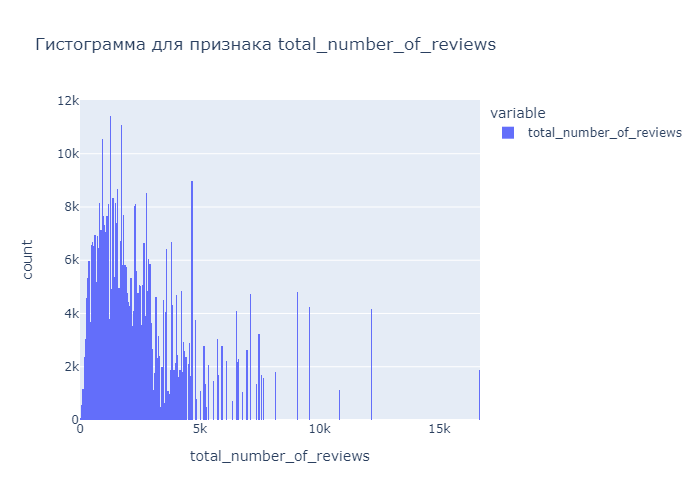

In [18]:
total_reviews_box = px.box(
    x=num_features['total_number_of_reviews'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака total_number_of_reviews',
    labels={'x': 'total_number_of_reviews'}
)
total_reviews_hist = px.histogram(
    num_features['total_number_of_reviews'],
    height=500,
    width=700,
    title='Гистограмма для признака total_number_of_reviews',
    labels={'value': 'total_number_of_reviews'}
)
total_reviews_box.show()
total_reviews_hist.show()

*total_number_of_reviews* также похож на признак с логнормальным распределением. У большинства отелей количество отзывов не превышает 5000, но всегда есть наиболее популярные и те, которые существуют довольно давно, поэтому выше 15000 отзывов - вполне логичное значение для подобных отелей. Оставляем признак как есть.

### *review_total_positive_word_counts*

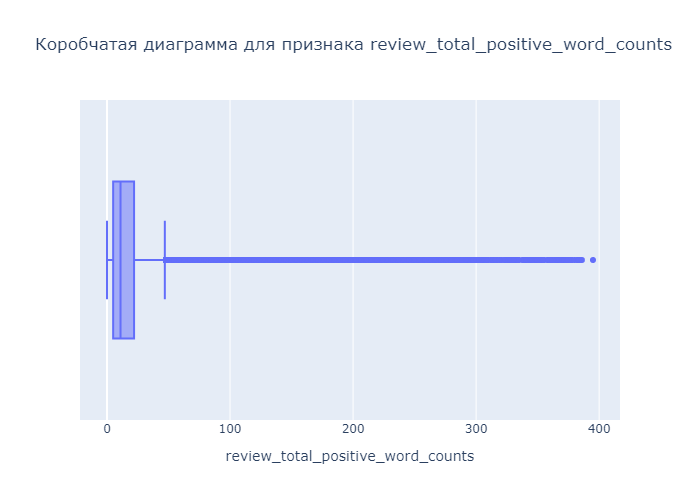

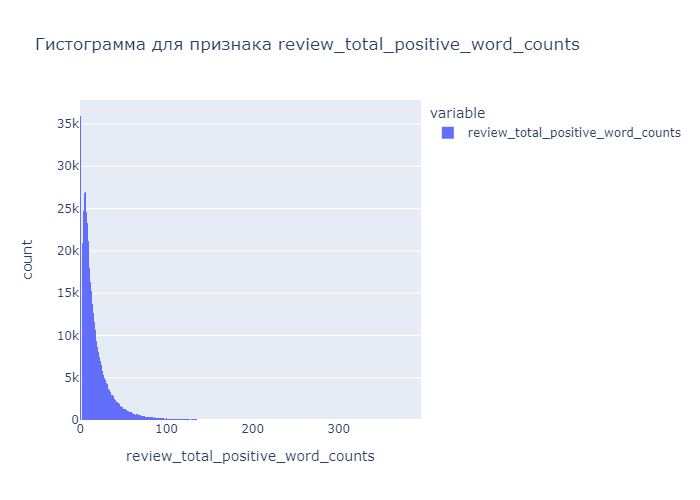

In [19]:
total_positive_box = px.box(
    x=num_features['review_total_positive_word_counts'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака review_total_positive_word_counts',
    labels={'x': 'review_total_positive_word_counts'}
)
total_positive_hist = px.histogram(
    num_features['review_total_positive_word_counts'],
    height=500,
    width=700,
    title='Гистограмма для признака review_total_positive_word_counts',
    labels={'value': 'review_total_positive_word_counts'}
)
total_positive_box.show()
total_positive_hist.show()

Данный признак аналогичен признаку *review_total_negative_word_counts* по смыслу, но отображает количество позитивных слов в отзыве.

### *total_number_of_reviews_reviewer_has_given*

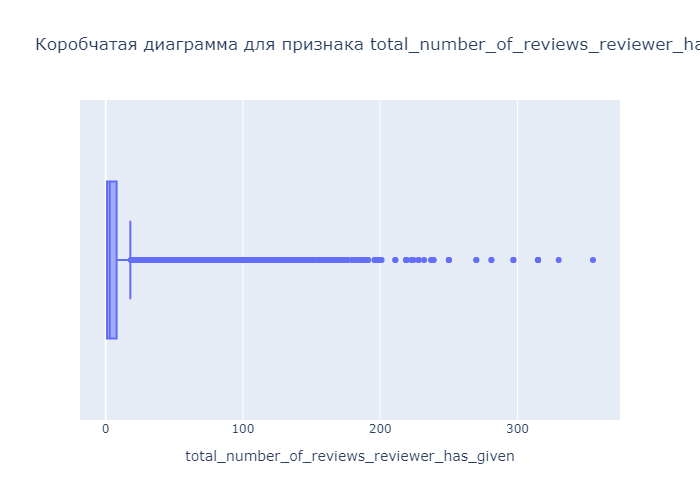

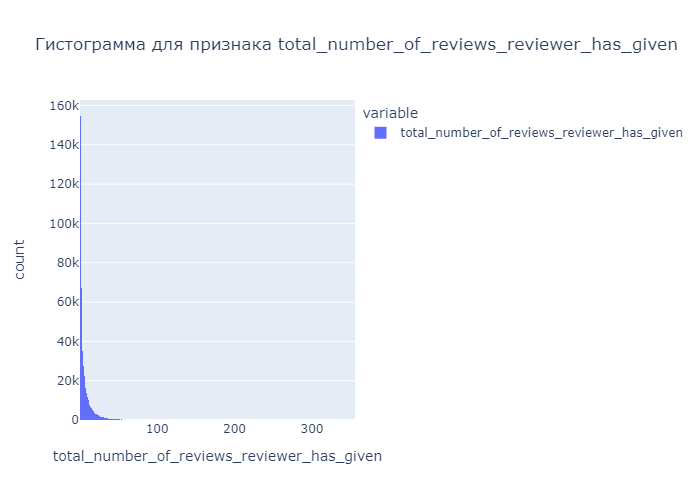

In [20]:
total_given_box = px.box(
    x=num_features['total_number_of_reviews_reviewer_has_given'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака total_number_of_reviews_reviewer_has_given',
    labels={'x': 'total_number_of_reviews_reviewer_has_given'}
)
total_given_hist = px.histogram(
    num_features['total_number_of_reviews_reviewer_has_given'],
    height=500,
    width=700,
    title='Гистограмма для признака total_number_of_reviews_reviewer_has_given',
    labels={'value': 'total_number_of_reviews_reviewer_has_given'}
)
total_given_box.show()
total_given_hist.show()

Данный признак можно интерпретировать как "надёжность ревьювера". Чем больше отзывов оставил ревьювер - тем выше шанс, что его отзывы будут объективны, т.к. человек довольно ответственно подходит к этому занятию - оставлять отзыв к чему-либо.

### *reviewer_score* (целевой признак)

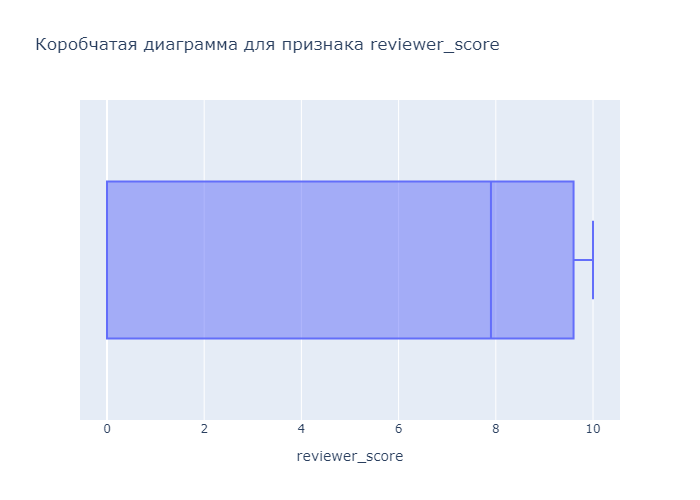

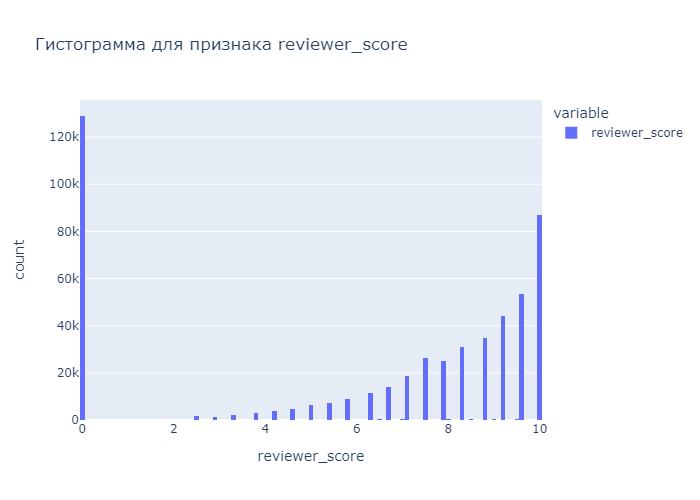

In [21]:
target_box = px.box(
    x=num_features['reviewer_score'],
    height=500,
    width=700,
    title='Коробчатая диаграмма для признака reviewer_score',
    labels={'x': 'reviewer_score'}
)
target_hist = px.histogram(
    num_features['reviewer_score'],
    height=500,
    width=700,
    title='Гистограмма для признака reviewer_score',
    labels={'value': 'reviewer_score'}
)
target_box.show()
target_hist.show()

Нули - заполненные нами вручную значения для предсказания, поэтому их не учитываем. Отрицательных значений не наблюдается, выше 10 - тоже нет. Можно сказать, что выбросов и аномальных значений нет в данном признаке. Однако это далеко не означает то, что все оценки проставленны объективно и справедливо.

***

## Заполняем пропущенные значения координат с помощью `geopy`

Посмотрим, в каких странах есть пропущенные значения.

In [22]:
countries_with_null = hotels[hotels['lat'].isna() | hotels['lng'].isna()]['country'].value_counts()
countries_with_null

Austria    2679
France      382
Spain       207
Name: country, dtype: int64

Можно заметить, что больше всего пропущенных значений находится в Австрии, а также есть во Франции и Испании.

Посмотрим на структуру адресов в этих странах, чтобы было проще заполнять пустые значения.

In [23]:
for country in countries_with_null.index:
    display(hotels[(hotels['lat'].isna() | hotels['lng'].isna()) 
                   & (hotels['country'] == country)].iloc[0].loc['hotel_address'])

'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria'

'23 Rue Damr mont 18th arr 75018 Paris France'

'Bail n 4 6 Eixample 08010 Barcelona Spain'

Видно, что последние 3 значения в строке представляют собой структуру *[postal code + city + country]*. Можем воспользоваться этой особенностью и заполнить пропущенные координаты с помощью библиотеки `geopy`.

Создадим отдельный датафрейм, который будет содержать в себе адрес, широту и долготу. Пропущенные значения заменим на строку, чтобы можно было заполнить эти значения с помощью метода `apply`, т.к. этот метод не работает с пропущенными (`NaN/None`) значениями.

In [24]:
address_coords = hotels[['hotel_address', 'lat', 'lng']].copy()
address_coords.fillna('unknown', inplace=True)
address_coords.head()

,hotel_address,lat,lng
0,Via Senigallia 6 20161 Milan Italy,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,52.385649,4.834443
2,Mallorca 251 Eixample 08008 Barcelona Spain,41.393192,2.16152
3,Piazza Della Repubblica 17 Central Station 201...,45.479888,9.196298
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,52.370545,4.888644


Отобразим, как выглядят на данном этапе наши пропущенные значения, а потом сравним их после преобразования.

In [25]:
null_indexes = address_coords[address_coords['lat'] == 'unknown'].index
address_coords.iloc[null_indexes]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,unknown,unknown
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,unknown,unknown
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,unknown,unknown
526,23 Rue Damr mont 18th arr 75018 Paris France,unknown,unknown
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,unknown,unknown
...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown
515439,4 rue de la P pini re 8th arr 75008 Paris France,unknown,unknown
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,unknown,unknown


Посмотрим на количество уникальных адресов.

In [26]:
address_coords.iloc[null_indexes]['hotel_address'].nunique()

17

Количество уникальных пропущенных адресов невелико, поэтому будем использовать запрос к [OpenStreetMap](https://www.openstreetmap.org/) с помощью библиотеки `geopy`.

In [27]:
# Создадим экземпляр класса Nominatim библиотеки geopy
geolocator = Nominatim(user_agent='project_3')
# Создадим экземпляр класса RateLimiter, чтобы ограничить задержку между запросами. В данном случае выполнение ячейки займет ~17 секунд
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

def get_coords(address:str) -> tuple:
    
    """Returns the latitude and longitude for the address

    Args:
        address (str): Address

    Returns:
        tuple: (latitude, longitude)
    """
    
    # Сократим адрес до формата {почтовый индекс + город + страна}, т.к. в "сыром" формате библиотека geopy может не распознать местоположение
    def get_short_address(address:str) -> str:
        
        """Returns address in format '%postal_code %city %country'
        
        Args:
            address (str): Raw format of address, where last 3 words is '%postal_code %city %country'
            
        Returns:
            str: Short address
        """
        
        short_address = ' '.join(address.split()[-3:])
        return short_address
    
    location = geocode(get_short_address(address))
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

unique_null_addresses = address_coords.iloc[null_indexes]['hotel_address'].unique()
# Создадим словарь, где ключем будет полный адрес, а значением - кортеж из широты и долготы
filled_addresses_dict = dict()
for address in unique_null_addresses:
    filled_addresses_dict[address] = get_coords(address)

Мы создали словарь из 17 различных адресов, где значениями является кортеж (широта, долгота). Теперь надо заполнить наши пропущенные значения с помощью этого словаря.

In [28]:
def fill_coords(address:str, lat, lng, dictionary:dict) -> tuple:
    
    """Returns the latitude and longitude value for the address key. It is recommended to use in combination with the pandas.apply() method

    Args:
        address (str): Address
        lat (any): Empty latitude column to fill
        lng (any): Empty longitude column to fill
        dictionary (dict): Dictionary to fill in latitude and longitude 

    Returns:
        tuple: (address, new latitude, new longitude)
    """
    
    lat = dictionary[address][0]
    lng = dictionary[address][1]
    
    return address, lat, lng

address_coords.iloc[null_indexes] = address_coords.iloc[null_indexes].apply(
    lambda row: fill_coords(row['hotel_address'], row['lat'], row['lng'], filled_addresses_dict),
    axis=1,
    result_type='broadcast'
)

Выведем строки, которые были пустыми, после того, как получили их координаты.

In [29]:
address_coords.iloc[null_indexes]

,hotel_address,lat,lng
35,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.222757,16.356334
293,W hringer Stra e 33 35 09 Alsergrund 1090 Vien...,48.222757,16.356334
476,Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...,48.222757,16.356334
526,23 Rue Damr mont 18th arr 75018 Paris France,48.889485,2.342177
569,Josefst dter Stra e 10 12 08 Josefstadt 1080 V...,48.211029,16.347425
...,...,...,...
515027,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042
515400,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042
515439,4 rue de la P pini re 8th arr 75008 Paris France,48.873751,2.314978
515637,Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...,48.214453,16.397042


Заменим пустые значения координат в нашем основном датафрейме на преобразованные. Теперь у нас нет пропусков в данных.

In [30]:
filled_coords = address_coords[['lat', 'lng']].copy()
hotels[['lat', 'lng']] = filled_coords
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
country                                       0
population                                    0
dtype: int64

Теперь нам больше не нужен признак с полным адресом отеля.

In [31]:
hotels.drop(columns='hotel_address', inplace=True)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country,population
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy,58.89
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands,17.80
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.16152,0,0.0,Spain,47.62


***

## Добавим признак с информацией о столице страны, в которой находится отель.

Возьмем таблицу столиц нужных нам стран с Википедии. Добавим для каждой столицы из датафрейма широту и долготу(пока что пустые значения, чтобы проще было заполнять на следующем этапе).

In [32]:
capitals_df = pd.read_html('https://en.wikipedia.org/wiki/List_of_national_capitals')[1]
capitals_df.drop(columns='Notes', axis=1, inplace=True)
capitals_df = capitals_df[capitals_df['Country/Territory'].isin(hotels['country'].unique())]
capitals_df = capitals_df.rename(columns={
    'City/Town': 'capital',
    'Country/Territory': 'country'
}).drop(index=13) # Удалим неофициальную столицу Нидерландов
capitals_df[['lat_cap', 'lng_cap']] = 'unknown'
# Удалим лишнюю информацию из названия столицы, например, приписку (official) 
capitals_df['capital'] = capitals_df['capital'].apply(lambda x: x.split()[0])
capitals_df

,capital,country,lat_cap,lng_cap
12,Amsterdam,Netherlands,unknown,unknown
134,London,United Kingdom,unknown,unknown
138,Madrid,Spain,unknown,unknown
180,Paris,France,unknown,unknown
199,Rome,Italy,unknown,unknown
248,Vienna,Austria,unknown,unknown


Заполним значения координат для столиц немного измененной функцией из раздела заполнения пропущенных значений.

In [33]:
def get_capital_coords(address:str) -> tuple:
    
    """Returns the latitude and longitude for the city

    Args:
        address (str): City name

    Returns:
        tuple: (latitude, longitude)
    """
    
    location = geocode(address)
    lat = location.latitude
    lng = location.longitude
    
    return lat, lng

capital_coords = dict()
for capital in capitals_df['capital'].values:
    capital_coords[capital] = get_capital_coords(capital)

capital_keys = ['capital', 'lat_cap', 'lng_cap']
capitals_df[capital_keys] = capitals_df[capital_keys].apply(
    lambda row: fill_coords(row['capital'], row['lat_cap'], row['lng_cap'], capital_coords),
    axis=1,
    result_type='broadcast'
)
capitals_df

,capital,country,lat_cap,lng_cap
12,Amsterdam,Netherlands,52.37308,4.892453
134,London,United Kingdom,51.507336,-0.12765
138,Madrid,Spain,40.416705,-3.703582
180,Paris,France,48.85889,2.320041
199,Rome,Italy,41.89332,12.482932
248,Vienna,Austria,48.208354,16.372504


Присоединим к основному датафрейму данные о столицах.

In [34]:
hotels = hotels.join(capitals_df.set_index('country'), on='country')
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,days_since_review,lat,lng,sample,reviewer_score,country,population,capital,lat_cap,lng_cap
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,13 days,45.533137,9.171102,0,0.0,Italy,58.89,Rome,41.89332,12.482932
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,234 day,52.385649,4.834443,0,0.0,Netherlands,17.80,Amsterdam,52.37308,4.892453
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,616 day,41.393192,2.16152,0,0.0,Spain,47.62,Madrid,40.416705,-3.703582


***

## Посчитаем расстояние между расположением отеля и столицей страны

Напишем функцию, которая будет для каждой строки считать расстояние(в километрах) между координатами отеля и координатами столицы страны. Используем функциональность библиотеки `geopy` и будем рассчитывать геодезическое расстояние. Удалим признаки широты и долготы, т.к. координаты не несут в себе смысла, ровно как и столбцы с любыми id. А также удалим название столицы, т.к. оно тоже не несёт в себе смысла и мы использовали его исключительно для того, чтобы получить координаты и посчитать расстояние.

In [35]:
def get_distance(lat_1:float, lng_1:float, lat_2:float, lng_2:float) -> float:
    
    """Returns distance between coordinates of 2 cities using 

    Args:
        lat_1 (float): latitude of first city
        lng_1 (float): longitude of first city
        lat_2 (float): latitude of second city
        lng_2 (float): longitude of second city

    Returns:
        float: Distance between 2 cities in kilometres
    """
    
    first_city = (lat_1, lng_1)
    second_city = (lat_2, lng_2)
    return np.round(geodesic(first_city, second_city).km, 0)
    
hotels['distance_to_capital'] = hotels[['lat', 'lng', 'lat_cap', 'lng_cap']].apply(
    lambda row: get_distance(row['lat'], row['lng'], row['lat_cap'], row['lng_cap']),
    axis=1
)
hotels.drop(columns=['lat', 'lng', 'lat_cap', 'lng_cap', 'capital'], inplace=True)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,population,distance_to_capital
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,58.89,484.0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,17.80,4.0
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,47.62,506.0


Так как мы считали расстояние до центра столицы, то можем создать следующий бинарный признак: находится ли отель в пределах столицы или нет. Обычно столицы - большие города. Условимся, что если расстояние до центра столицы составляет более 50 км - значит отель находится в другом городе. 

In [36]:
# Отдалённость от центра столицы
distance = 50
hotels['is_capital'] = hotels['distance_to_capital'].apply(
    lambda distance_to_capital: int(distance_to_capital <= distance)
)
hotels.head(2)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,population,distance_to_capital,is_capital
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,58.89,484.0,0
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,17.80,4.0,1


***

## Добавим индекс удовлетворённости жизнью в стране отеля

In [37]:
life_satisfaction = pd.read_html('https://en.wikipedia.org/wiki/Satisfaction_with_Life_Index')[1]
# Таблица на Википедии немного не в том формате, который нас интересует, поэтому продолжение таблицы сделаем не "справа", а "снизу"
life_satisfaction = pd.concat([life_satisfaction.iloc[:, [0, 1, 2]],
                               life_satisfaction.iloc[:, [3, 4, 5]].rename({
                                    'Rank.1': 'Rank',
                                    'Country.1': 'Country',
                                    'SWL.1': 'SWL'}, axis=1)],
                              axis=0).reset_index().drop(columns=['index', 'Rank'])
life_satisfaction

,Country,SWL
0,Denmark,283.33
1,Switzerland,273.33
2,Austria,260.00
3,Iceland,260.00
4,The Bahamas,266.67
...,...,...
173,Ukraine,120.00
174,Moldova,116.67
175,Democratic Republic of the Congo,110.00
176,Zimbabwe,110.00


Присоединим индекс удовлетворённости к основного датафрейму.

In [38]:
hotels = hotels.join(life_satisfaction.set_index('Country'), on='country')
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,sample,reviewer_score,country,population,distance_to_capital,is_capital,SWL
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,0,0.0,Italy,58.89,484.0,0,230.00
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,0,0.0,Netherlands,17.80,4.0,1,250.00
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,0,0.0,Spain,47.62,506.0,0,233.33


***

## Преобразование отзывов

Создадим признак, который будет представлять из себя соотношение количества слов в положительном отзыве к количеству слов в отрицательном отзыве. Добавим 1 к каждому столбцу, чтобы не получить исключение деления на ноль или не получить сам 0, если будет много негативных слов, но не будет позитивных.

In [39]:
hotels['review_rate'] = (hotels['review_total_positive_word_counts'] + 1) / (hotels['review_total_negative_word_counts'] + 1)

Взглянем на примеры отзывов.

In [40]:
reviews = hotels[['negative_review', 'positive_review']]
reviews.head()

,negative_review,positive_review
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...
1,No tissue paper box was present at the room,No Positive
2,Pillows,Nice welcoming and service
3,No Negative,Everything including the nice upgrade The Hot...
4,No Negative,Lovely hotel v welcoming staff


Взглянем на топ-15 каждой категории отзывов.

In [41]:
display(
    reviews['negative_review'].value_counts().head(15),
    reviews['positive_review'].value_counts().head(15)
)

No Negative        127890
 Nothing            14295
 Nothing             4236
 nothing             2225
 N A                 1037
 None                 984
                      849
 N a                  509
 Breakfast            407
 Small room           373
 Location             368
 Everything           326
 All good             318
 Nothing really       316
 none                 302
Name: negative_review, dtype: int64

No Positive            35946
 Location               9222
 Everything             2284
 location               1677
 Nothing                1243
 The location           1126
 Great location         1047
 Good location           927
 Location                915
 Everything              613
 Breakfast               608
 Friendly staff          515
 Staff                   453
 Excellent location      392
 Great location          372
Name: positive_review, dtype: int64

Можно заметить неоднозначеные ответы, например "No Negative" / "No Positive". Посмотрим, правильно ли понимает смысл таких выражений анализатор текста.

In [42]:
# Создадим класс библиотеки nltk
sent_analyzer = SentimentIntensityAnalyzer()
display(sent_analyzer.polarity_scores('No Negative'),
        sent_analyzer.polarity_scores('No Positive'))

{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.7096}

{'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'compound': 0.34}

Ответы не совсем похожи на то, что мы ожидаем. С точки зрения человеческой речи 'No Negative' означает положительный смысл(отсутствие отрицательных эмоций), в то же время 'No Positive' означает отрицательный смысл(отсутствие положительных эмоций). Учтём данную особенность в кодировании отзывов и самостоятельно преобразуем подобные выражения так, чтобы они передавали верный смысл.

Теперь мы можем закодировать данные отзывы с помощью анализатора текста библиотеки `nltk`. (Ячейка выполняется относительно долго, в моём случае - 2 минуты)

In [43]:
def encode_review(pos_review:str, neg_review:str):
    
    if pos_review.lower() == 'no positive':
        pos_review = 'negative'
    if neg_review.lower() == 'no negative':
        neg_review = 'positive'
    
    pos_score = sent_analyzer.polarity_scores(pos_review)
    neg_score = sent_analyzer.polarity_scores(neg_review)

    result = (pos_score['neg'], pos_score['neu'], pos_score['pos'], pos_score['compound'],
              neg_score['neg'], neg_score['neu'], neg_score['pos'], neg_score['compound'])
    
    return result

polarity_score_keys = ['pos_neg', 'pos_neu', 'pos_pos', 'pos_compound', 
                       'neg_neg', 'neg_neu', 'neg_pos', 'neg_compound']



reviews[polarity_score_keys] = reviews[['positive_review', 'negative_review']].apply(
    lambda row: encode_review(row['positive_review'], row['negative_review']),
    axis=1,
    result_type='expand'
)
reviews.head()

,negative_review,positive_review,pos_neg,pos_neu,pos_pos,pos_compound,neg_neg,neg_neu,neg_pos,neg_compound
0,Would have appreciated a shop in the hotel th...,Hotel was great clean friendly staff free bre...,0.0,0.671,0.329,0.9615,0.129,0.747,0.125,-0.0554
1,No tissue paper box was present at the room,No Positive,1.0,0.000,0.000,-0.5719,0.216,0.784,0.000,-0.2960
2,Pillows,Nice welcoming and service,0.0,0.260,0.740,0.6908,0.000,1.000,0.000,0.0000
3,No Negative,Everything including the nice upgrade The Hot...,0.0,0.621,0.379,0.9153,0.000,0.000,1.000,0.5574
4,No Negative,Lovely hotel v welcoming staff,0.0,0.230,0.770,0.7717,0.000,0.000,1.000,0.5574


Посмотрим на распределение новых числовых признаков для отзывов

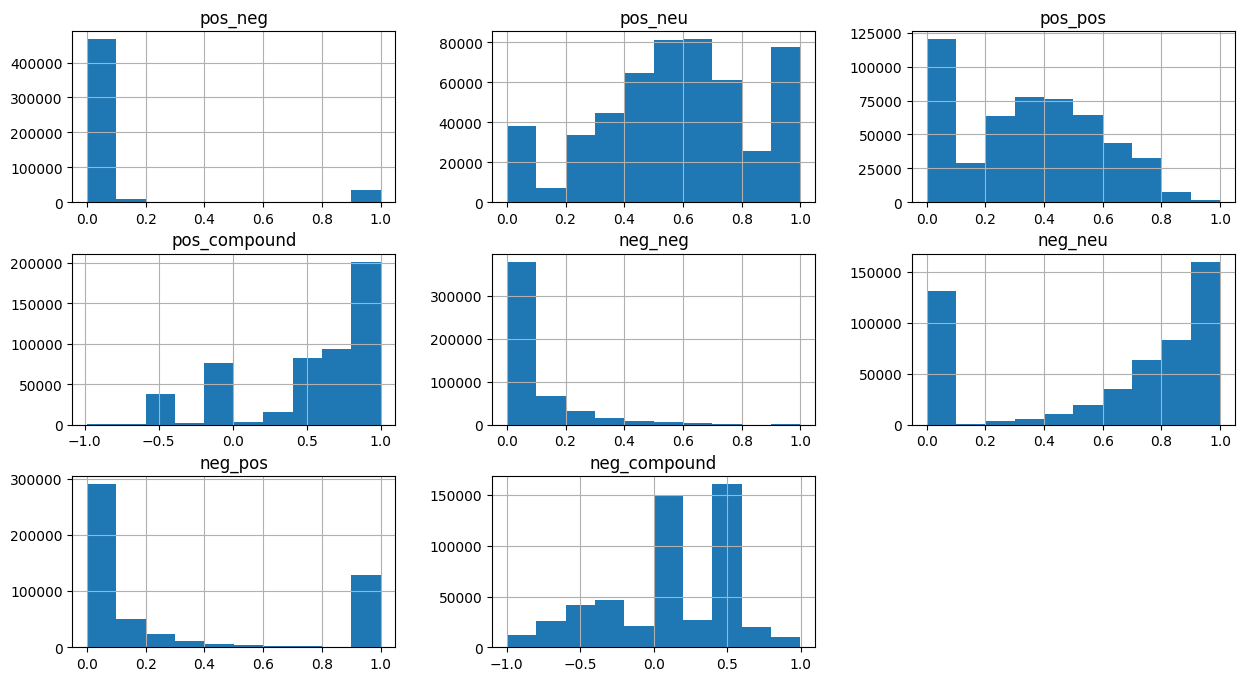

In [44]:
reviews.hist(figsize=(15, 8));

Как видим, признаки расположены ненормально, поэтому используем корреляцию Спирмена, чтобы посмотреть, есть ли среди них мультиколлинеарность.

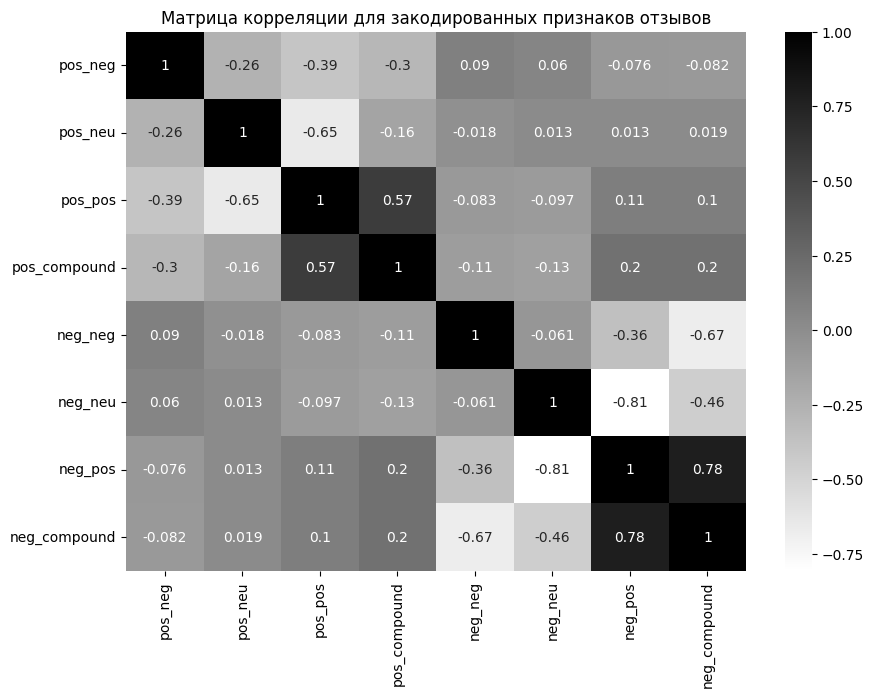

In [45]:
plt.figure(figsize=(10, 7))
corr_heatmap = sns.heatmap(reviews.corr(numeric_only=True, method='spearman'), annot=True, cmap='binary')
corr_heatmap.set_title('Матрица корреляции для закодированных признаков отзывов');

Наблюдается сильная корреляция признаков *neg_pos* и *neg_neu*, равная $-0.81$, а также между признаками *neg_pos* и *neg_compound*, равная $0.78$. Удалим *neg_pos*, т.к. он коррелирует сразу с двумя другими признаками.

In [46]:
del polarity_score_keys[-2] # удаляем имя признака neg_pos из списка
all_reviews = ['positive_review', 'negative_review']
hotels = pd.concat([hotels.drop(columns=all_reviews), reviews[polarity_score_keys]], axis=1)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,...,is_capital,SWL,review_rate,pos_neg,pos_neu,pos_pos,pos_compound,neg_neg,neg_neu,neg_compound
0,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,52,16670,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",...,0,230.00,1.188679,0.0,0.671,0.329,0.9615,0.129,0.747,-0.0554
1,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,10,5018,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",...,1,250.00,0.090909,1.0,0.000,0.000,-0.5719,0.216,0.784,-0.2960
2,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,3,351,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",...,0,233.33,1.500000,0.0,0.260,0.740,0.6908,0.000,1.000,0.0000


***

## Анализ категориальных признаков

Посмотрим, сколько категориальных признаков ещё осталось.

In [48]:
cat_hotels = hotels[[col for col in hotels.columns if hotels[col].dtype == 'object']].copy()
cat_hotels.info()
cat_hotels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   review_date           515738 non-null  object
 1   hotel_name            515738 non-null  object
 2   reviewer_nationality  515738 non-null  object
 3   tags                  515738 non-null  object
 4   days_since_review     515738 non-null  object
 5   country               515738 non-null  object
dtypes: object(6)
memory usage: 23.6+ MB


,review_date,hotel_name,reviewer_nationality,tags,days_since_review,country
0,7/21/2017,Hotel Da Vinci,United Kingdom,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,Italy
1,12/12/2016,Urban Lodge Hotel,Belgium,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,Netherlands
2,11/26/2015,Alexandra Barcelona A DoubleTree by Hilton,Sweden,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,Spain
3,10/17/2015,Hotel Principe Di Savoia,United States of America,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,Italy
4,5/16/2016,Hotel Esther a,United Kingdom,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,Netherlands


Посмотрим, сколько уникальных значений в признаках. Признак tags позже проанализируем отдельно.

In [49]:
cat_hotels.nunique()

review_date               731
hotel_name               1492
reviewer_nationality      227
tags                    55242
days_since_review         731
country                     6
dtype: int64

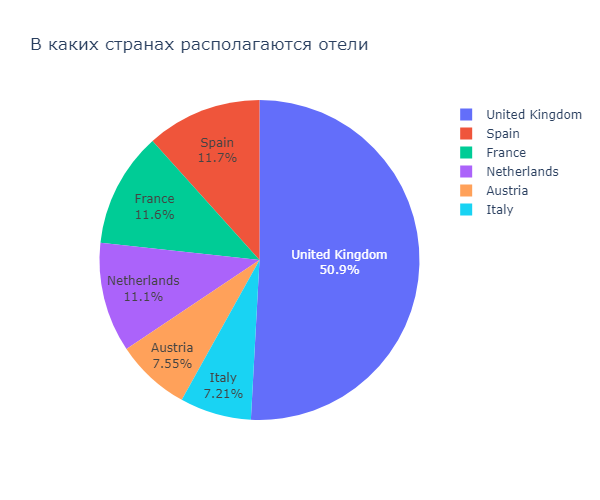

In [50]:
countries_pie = px.pie(
    cat_hotels.sort_values(by='country'),
    names='country',
    width=600,
    height=500,
    title='В каких странах располагаются отели'
)
countries_pie.update_traces(textposition='inside', textinfo='percent+label')

Преобразуем признак количества дней в числовой.

In [51]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda days: int(days.split()[0]))

***

## Кодируем категориальные признаки

Для *country* подойдёт OneHotEncoder, это создаст всего 7 доп.признаков.

In [52]:
one_hot_encoder = ce.OneHotEncoder(use_cat_names=True)
encoded_country = one_hot_encoder.fit_transform(cat_hotels['country'])
encoded_country.head()

,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,0,1,0,0,0,0


Для признака *tags* воспользуемся другим подходом и сделаем из него числовой признак. Для начала распакуем из каждой строки все тэги, после чего посчитаем количество уникальных для всех строк во всём датафрейме.

In [53]:
def clean_tags(tags:str) -> list:
    stop_chars = ['[', ']', '\' ', ' \'']
    for char in stop_chars:
        tags = tags.replace(char, '')
    return tags.split(', ')

print('Количество уникальных тэгов:', cat_hotels['tags'].apply(clean_tags).explode().nunique())
cleaned_tags = pd.DataFrame(cat_hotels['tags'].apply(clean_tags))
cleaned_tags

Количество уникальных тэгов: 2428


,tags
0,"[Leisure trip, Couple, Double Room, Stayed 2 n..."
1,"[Leisure trip, Group, Triple Room, Stayed 1 ni..."
2,"[Business trip, Solo traveler, Twin Room, Stay..."
3,"[Leisure trip, Couple, Ambassador Junior Suite..."
4,"[Business trip, Solo traveler, Classic Double ..."
...,...
515733,"[Leisure trip, Group, Club Double or Twin Room..."
515734,"[Leisure trip, Couple, Standard Double Room, S..."
515735,"[Business trip, Solo traveler, Single Room, St..."
515736,"[Leisure trip, Solo traveler, Deluxe Double Ro..."


Взглянем, какие бывают типы поездок.

In [76]:
unpacked_tags = pd.DataFrame(cleaned_tags['tags'].explode())
print('Типы поездок')
display(unpacked_tags[unpacked_tags['tags'].apply(lambda tag: 'trip' in tag)].value_counts())
print('Типы комнат(топ-10)')
display(unpacked_tags[unpacked_tags['tags'].apply(lambda tag: 'room' in tag)].value_counts().nlargest(10))
print('Всего уникальных комнат')
display(unpacked_tags[unpacked_tags['tags'].apply(lambda tag: 'room' in tag)].nunique())
print('На сколько ночей остаются(топ-10)')
display(unpacked_tags[unpacked_tags['tags'].apply(lambda tag: 'Stayed' in tag)].value_counts().nlargest(10))

Типы поездок


tags         
Leisure trip     417778
Business trip     82939
dtype: int64

Типы комнат(топ-10)


tags                                     
2 rooms                                      12393
Double Hilton Guestroom                       1300
One Bedroom Suite                              661
3 rooms                                        474
One Bedroom Apartment                          358
Deluxe One Bedroom Apartment                   348
Two Bedroom Apartment                          180
Deluxe One Bedroom Suite                       133
Compact Double Room with Private Bathroom      128
Queen Guestroom                                112
dtype: int64

Всего уникальных комнат


tags    124
dtype: int64

На сколько ночей остаются(топ-10)


tags            
Stayed 1 night      193645
Stayed 2 nights     133937
Stayed 3 nights      95821
Stayed 4 nights      47817
Stayed 5 nights      20845
Stayed 6 nights       9776
Stayed 7 nights       7399
Stayed 8 nights       2502
Stayed 9 nights       1293
Stayed 10 nights       889
dtype: int64

Закодируем подобные тэги следующим образом:
* Типа поездок всего 2, поэтому закодируем их с помощью `OneHotEncoder`; 
* Комнат довольно много и они сильно отличаются по названию, используем `BinaryEncoder`;
* Для количества ночей подойдет следующая логика - создать один столбец, в котором будет содержаться количество ночей для каждой записи(0, если не указано).

In [111]:
def get_trip(tags:list):
    result = -1
    if 'Leisure trip' in tags:
        result = 0
    if 'Business trip' in tags:
        result = 1
    return result
    
cleaned_tags['trip_type'] = cleaned_tags['tags'].apply(get_trip)

In [112]:
def get_room(tags:list):
    
    room = 'unknown'
    
    for index, tag in enumerate(tags):
        if 'room' in tag.lower():
            room = tags[index]
            
    return room

cleaned_tags['room_type'] = cleaned_tags['tags'].apply(get_room)

In [113]:
def get_nights(tags:list):
    
    nights = 0
    
    for index, tag in enumerate(tags):
        if 'stayed' in tag.lower():
            # Берём второй элемент из строки "Stayed %n% nights"
            nights = int(tag.split()[1])
            
    return nights
    
cleaned_tags['nights'] = cleaned_tags['tags'].apply(get_nights)
cleaned_tags.head()

,tags,room_type,nights,trip_type
0,"[Leisure trip, Couple, Double Room, Stayed 2 n...",Double Room,2,0
1,"[Leisure trip, Group, Triple Room, Stayed 1 ni...",Triple Room,1,0
2,"[Business trip, Solo traveler, Twin Room, Stay...",Twin Room,1,1
3,"[Leisure trip, Couple, Ambassador Junior Suite...",unknown,1,0
4,"[Business trip, Solo traveler, Classic Double ...",Classic Double or Twin Room,2,1


Теперь закодируем *room_type* с помощью `BinaryEncoder` и удалим лишние стобцы.

In [114]:
bin_encoder = ce.BinaryEncoder()
bin_room_types = bin_encoder.fit_transform(cleaned_tags['room_type'])
encoded_tags = pd.concat([cleaned_tags, bin_room_types], axis=1).drop(columns=['tags', 'room_type'])
encoded_tags.head()

,nights,trip_type,room_type_0,room_type_1,room_type_2,room_type_3,room_type_4,room_type_5,room_type_6,room_type_7,room_type_8,room_type_9,room_type_10
0,2,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,0,1,0
2,1,1,0,0,0,0,0,0,0,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,1,0,0
4,2,1,0,0,0,0,0,0,0,0,1,0,1


Выделим время года из даты отзыва.

In [115]:
seasons = {
    '12, 1, 2': 'winter',
    '3, 4, 5': 'spring',
    '6, 7, 8': 'summer',
    '9, 10, 11': 'autumn'
}
def get_season(date:str):
    
    month = date.split('/')[0]
    
    for key in seasons.keys():
        if month in key:
            return seasons[key]
    
seasons_df = hotels['review_date'].apply(get_season)
seasons_df.name = 'season'
seasons_df.head()

0    summer
1    winter
2    autumn
3    autumn
4    spring
Name: season, dtype: object

Закодируем время года с помощью `OneHotEncoder`.

In [116]:
encoded_seasons = one_hot_encoder.fit_transform(seasons_df)
encoded_seasons.head()

,season_summer,season_winter,season_autumn,season_spring
0,1,0,0,0
1,0,1,0,0
2,0,0,1,0
3,0,0,1,0
4,0,0,0,1


Закодируем признак национальности. Возьмем топ-20 наиболее часто встречающихся, остальные пометим как other.

In [117]:
# Применяем функцию к столбцу, чтобы очистить строку от лишних пробелов слева и справа
top_nationalities = hotels['reviewer_nationality'].apply(lambda nationality: nationality[1: -1]).value_counts().nlargest(20).index
nationalities = hotels['reviewer_nationality'].apply(
    lambda nationality: nationality[1: -1]).apply(
        lambda nationality: nationality if nationality in top_nationalities else 'other')

encoded_nationality = bin_encoder.fit_transform(nationalities)
encoded_nationality.head()

,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4
0,0,0,0,0,1
1,0,0,0,1,0
2,0,0,0,1,1
3,0,0,1,0,0
4,0,0,0,0,1


Создадим признак, является ли рецензент жителем страны, в отелей которой он поселился.

In [118]:
is_citizen = (cat_hotels['country'] == cat_hotels['reviewer_nationality'].apply(
    lambda nationality: nationality[1:-1])).astype(int)
is_citizen.name = 'is_citizen'
is_citizen.head()

0    0
1    0
2    0
3    0
4    0
Name: is_citizen, dtype: int32

In [119]:
encoded_cats = pd.concat([encoded_country, encoded_tags, encoded_seasons, encoded_nationality, is_citizen], axis=1)
encoded_cats.head()

,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria,nights,trip_type,room_type_0,room_type_1,...,season_summer,season_winter,season_autumn,season_spring,reviewer_nationality_0,reviewer_nationality_1,reviewer_nationality_2,reviewer_nationality_3,reviewer_nationality_4,is_citizen
0,1,0,0,0,0,0,2,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0,1,0,0,0,0,2,1,0,0,...,0,0,0,1,0,0,0,0,1,0


Проверим признаки на мультиколлинеарность с помощью матрицы корреляции Спирмена (для категориальных значений).

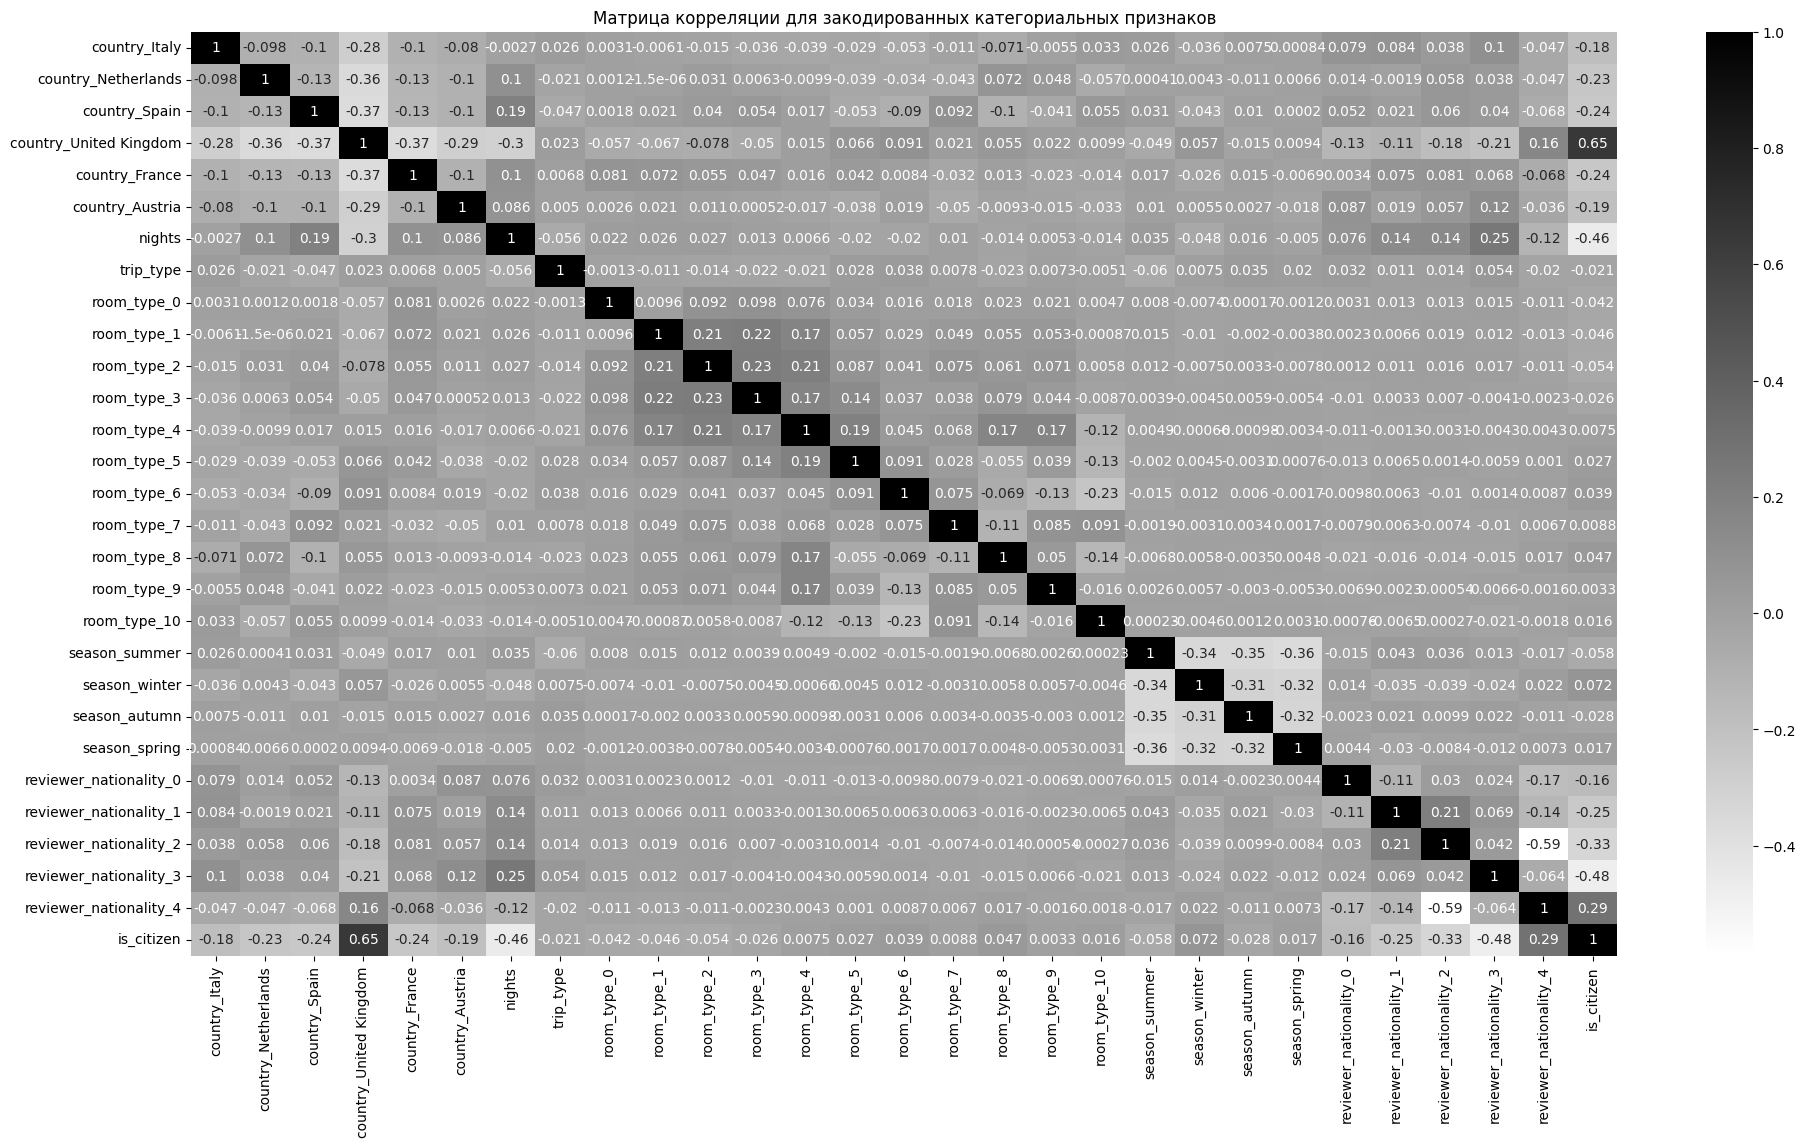

In [120]:
plt.figure(figsize=(23, 12))
corr_heatmap = sns.heatmap(encoded_cats.corr(method='spearman'), annot=True, cmap='binary')
corr_heatmap.set_title('Матрица корреляции для закодированных категориальных признаков');

Мультиколлинеарность не наблюдается, оставим в таком виде.

***

## Анализ числовых признаков

Теперь проверим все числовые признаки на мультиколлинеарность.

In [121]:
extra_cols = polarity_score_keys.copy()
# Не будем использовать уже проанализированные признаки закодированных отзывов, целевой столбец, индикатор train/test и индикатор столицы
extra_cols.extend(['sample', 'reviewer_score', 'is_capital'])
num_hotels = pd.concat([
    hotels[[col for col in hotels.columns if hotels[col].dtype != 'object']].drop(columns=extra_cols),
    #encoded_tags
    ], axis=1)
num_hotels.head()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,population,distance_to_capital,SWL,review_rate
0,904,8.1,52,16670,62,1,13,58.89,484.0,230.00,1.188679
1,612,8.6,10,5018,0,7,234,17.80,4.0,250.00,0.090909
2,46,8.3,3,351,5,15,616,47.62,506.0,233.33,1.500000
3,241,9.1,0,1543,27,9,656,58.89,478.0,230.00,28.000000
4,834,9.1,0,4687,7,2,444,17.80,0.0,250.00,8.000000


Построим гистограмму и определим, как распределены данные признаки.

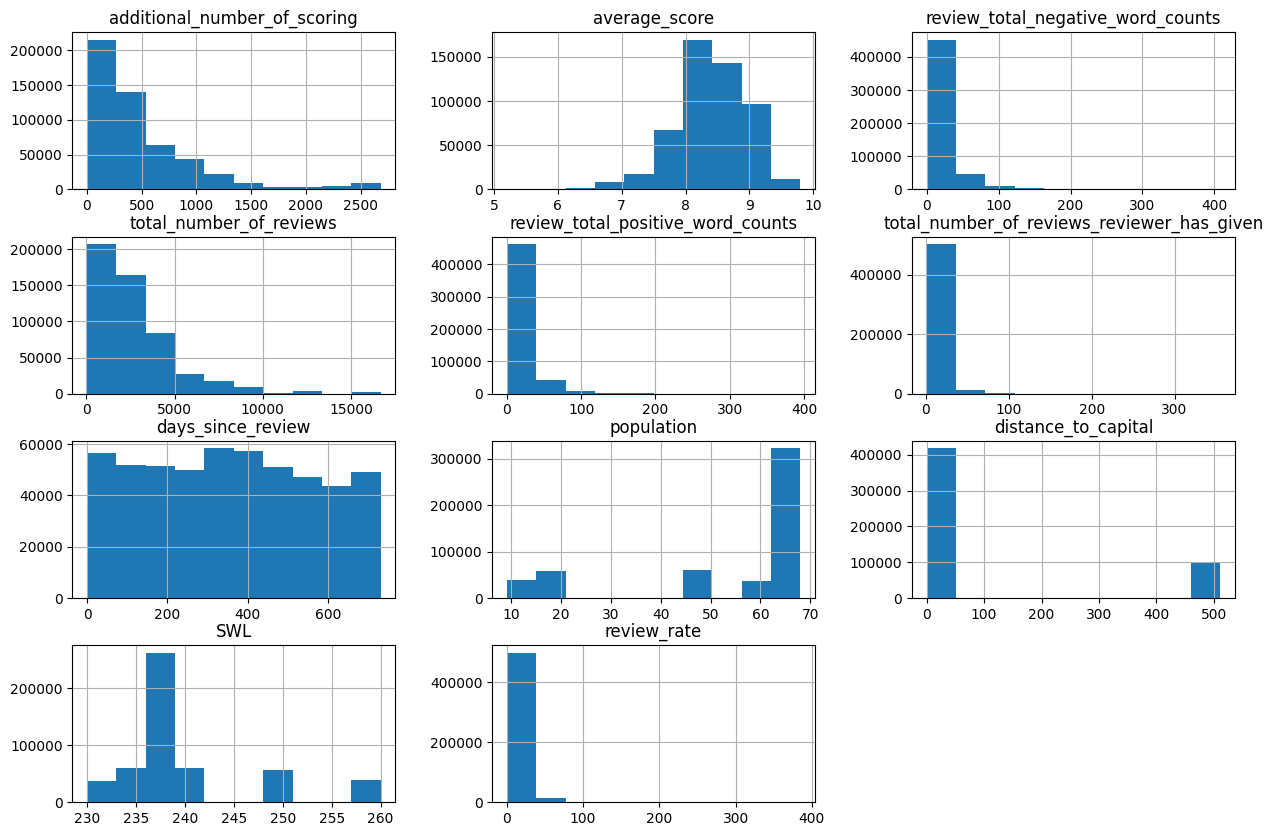

In [122]:
num_hotels.hist(figsize=(15, 10));

На нормальное распределение похож только 1 признак - *average_score*. Корреляция Пирсона не подходит, будем использовать Спирмана.

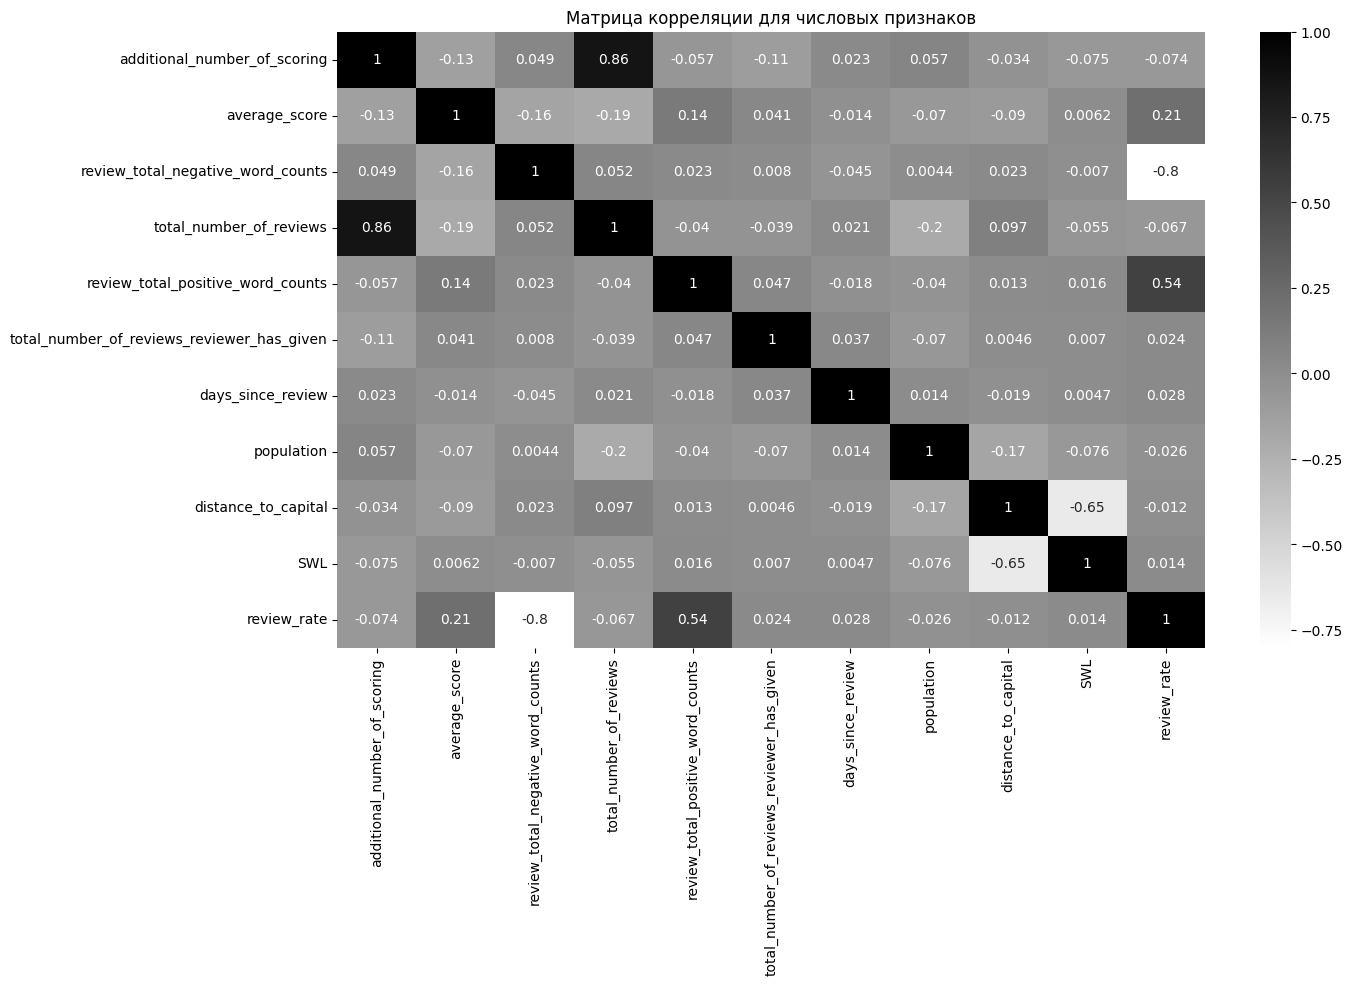

In [123]:
plt.figure(figsize=(14, 8))
corr_heatmap = sns.heatmap(num_hotels.corr(method='spearman'), cmap='binary', annot=True)
corr_heatmap.set_title('Матрица корреляции для числовых признаков');

Наблюдается сильная корреляция между признаками *additional_number_of_scoring* и *total_number_of_reviews*. Будет целесообразно удалить *additional_number_of_scoring*, т.к. это значение показывает, сколько гостей отеля поставили оценку, но не оставили отзыв. 

*review_total_negative_word_count* оставим, т.к. данный признак хоть и коррелирует с *review_rate*, но является важным.

In [124]:
num_hotels.drop(columns='additional_number_of_scoring', inplace=True)

***

## Объединим все созданные и числовые признаки в один датафрейм.

In [129]:
hotels_encoded = pd.concat([
    num_hotels,
    encoded_cats,
    hotels[extra_cols]
], axis=1)
hotels_encoded.head()

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,population,distance_to_capital,SWL,review_rate,...,pos_neg,pos_neu,pos_pos,pos_compound,neg_neg,neg_neu,neg_compound,sample,reviewer_score,is_capital
0,8.1,52,16670,62,1,13,58.89,484.0,230.00,1.188679,...,0.0,0.671,0.329,0.9615,0.129,0.747,-0.0554,0,0.0,0
1,8.6,10,5018,0,7,234,17.80,4.0,250.00,0.090909,...,1.0,0.000,0.000,-0.5719,0.216,0.784,-0.2960,0,0.0,1
2,8.3,3,351,5,15,616,47.62,506.0,233.33,1.500000,...,0.0,0.260,0.740,0.6908,0.000,1.000,0.0000,0,0.0,0
3,9.1,0,1543,27,9,656,58.89,478.0,230.00,28.000000,...,0.0,0.621,0.379,0.9153,0.000,0.000,0.5574,0,0.0,0
4,9.1,0,4687,7,2,444,17.80,0.0,250.00,8.000000,...,0.0,0.230,0.770,0.7717,0.000,0.000,0.5574,0,0.0,1


In [130]:
hotels_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 49 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   average_score                               515738 non-null  float64
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   total_number_of_reviews                     515738 non-null  int64  
 3   review_total_positive_word_counts           515738 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 5   days_since_review                           515738 non-null  int64  
 6   population                                  515738 non-null  float64
 7   distance_to_capital                         515738 non-null  float64
 8   SWL                                         515738 non-null  float64
 9   review_rate                                 515738 non-null  float64
 

Все наши признаки теперь являются числами и могут быть поданы в модель для обучения.

Взглянем на матрицу корреляции для всего датафрейма, на который будет использоваться для обучения модели.

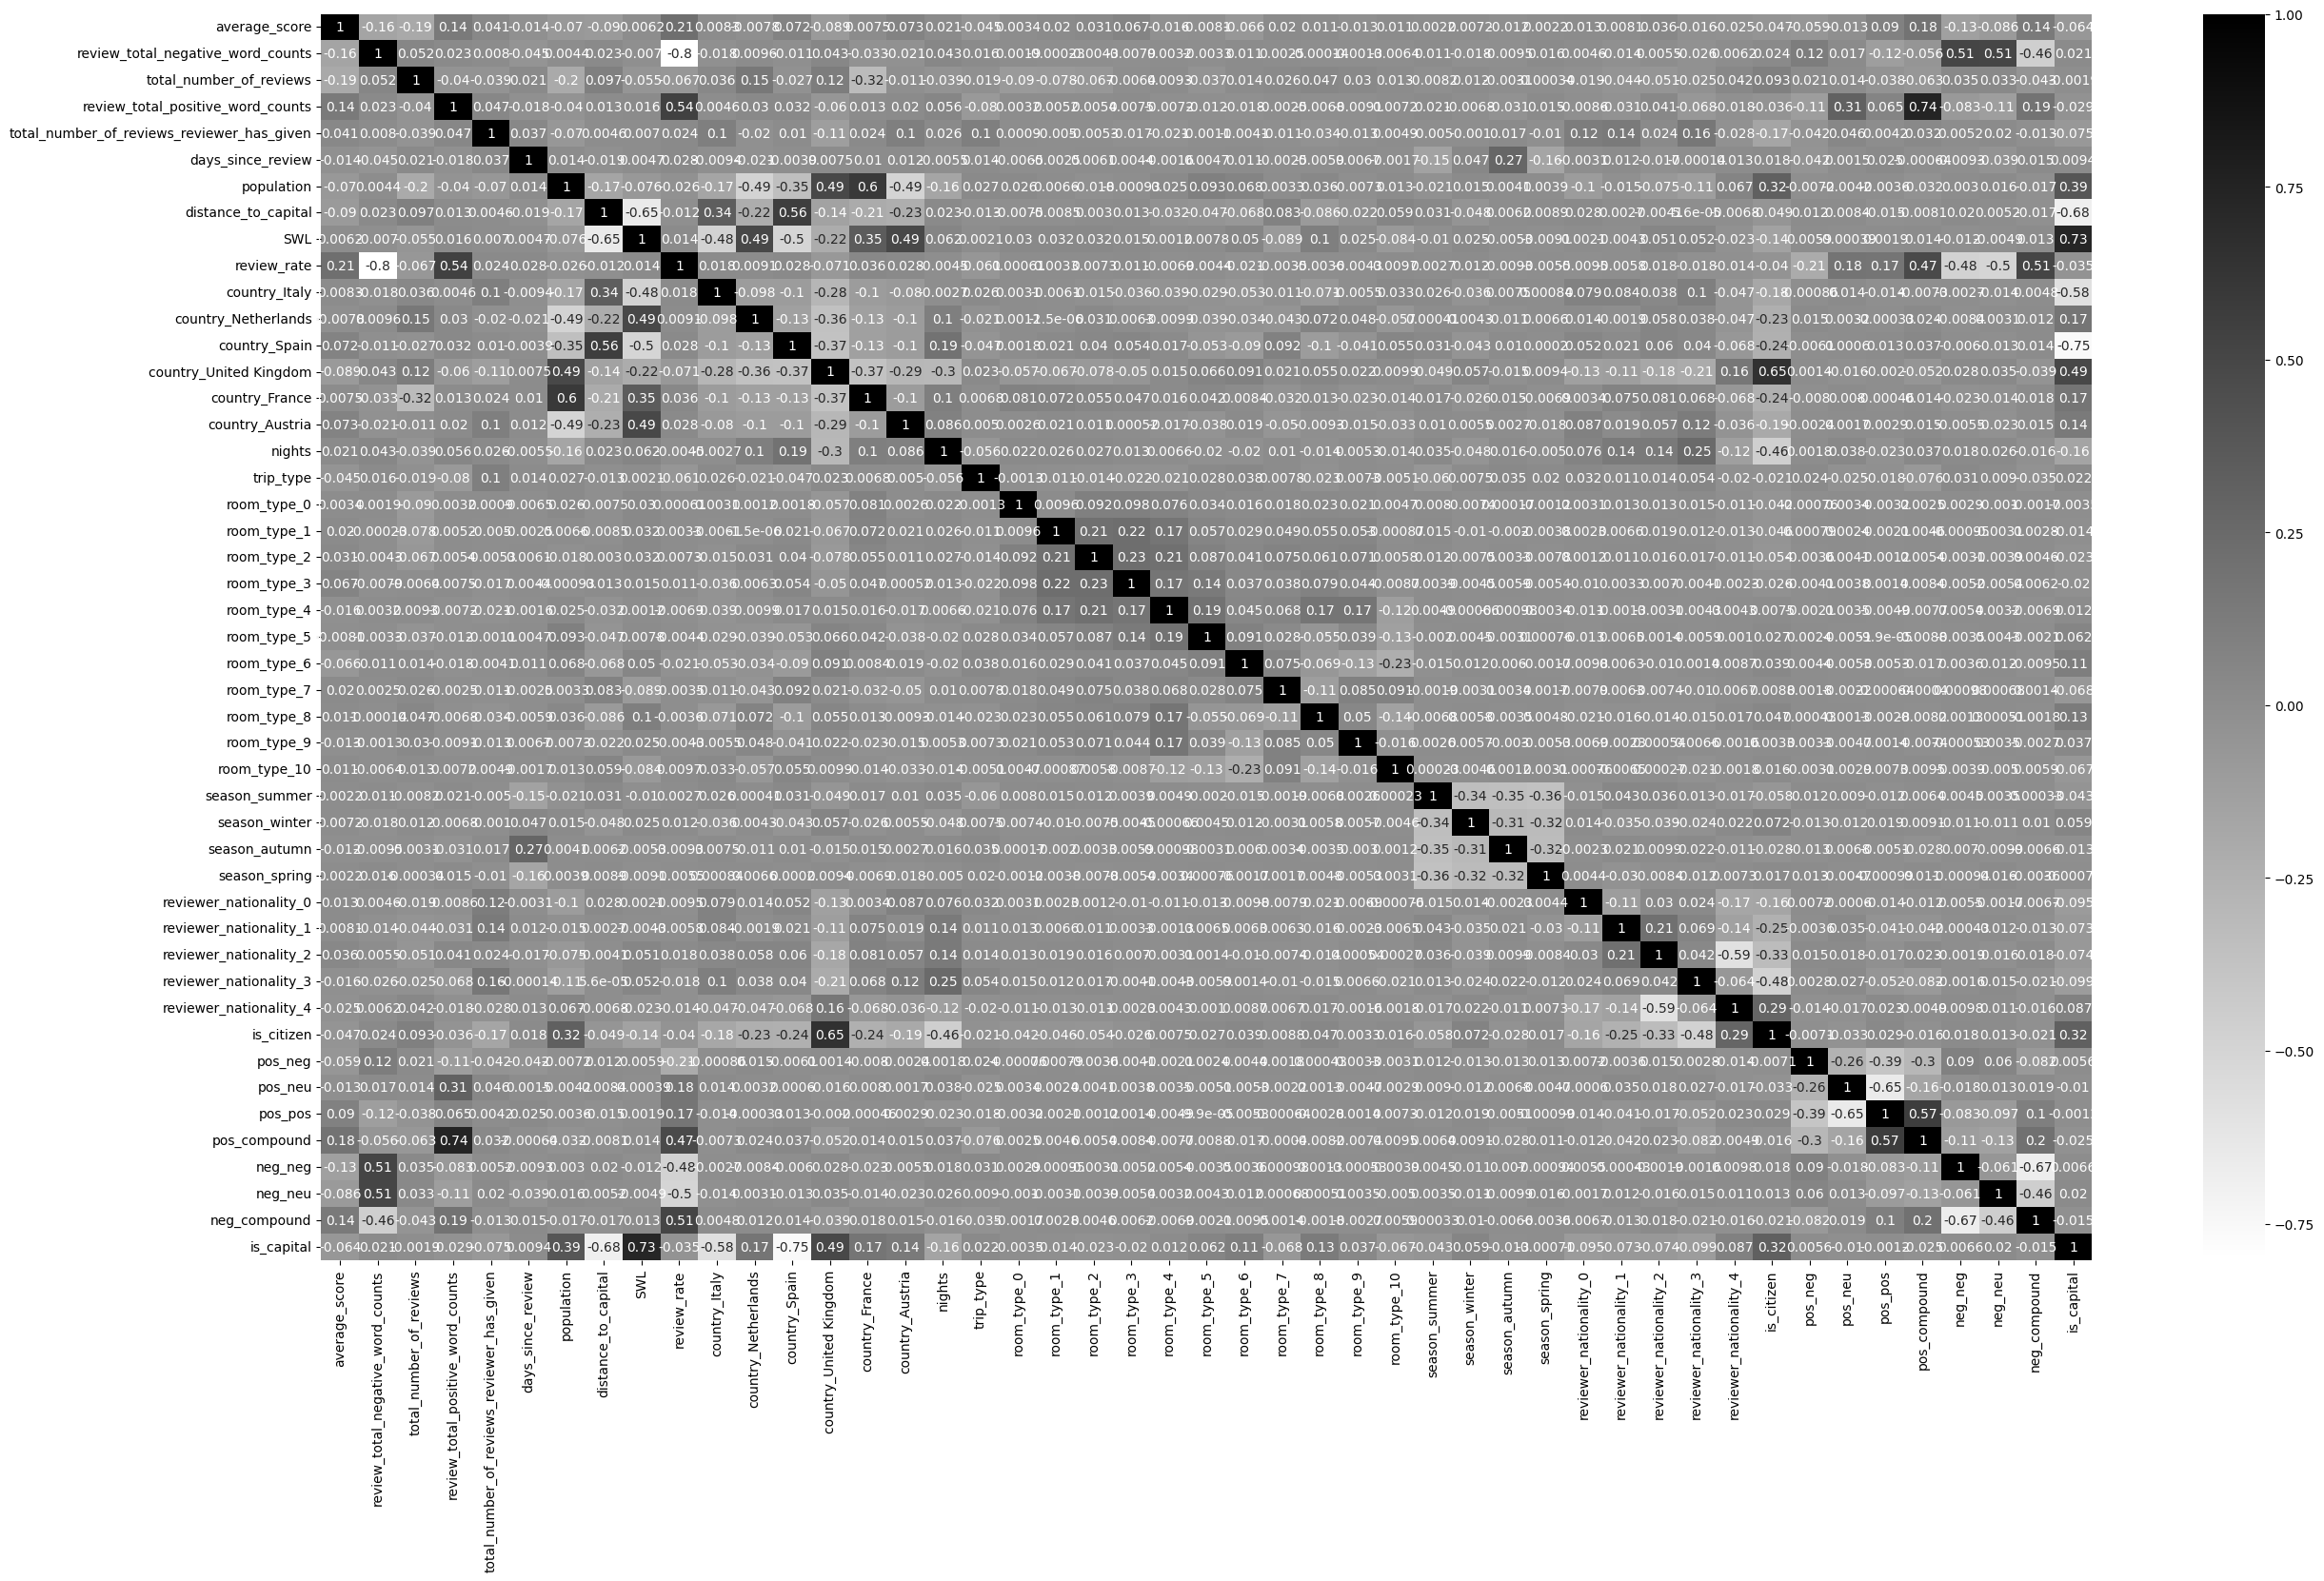

In [132]:
plt.figure(figsize=(30, 17))
corr_heatmap = sns.heatmap(hotels_encoded.drop(columns=['sample', 'reviewer_score']).corr(method='spearman'), annot=True, cmap='binary');

Мультиколлинеарность не наблюдается между признаками. $-0.8$ мы сознательно оставили, а взаимосвязь Испании с тем, является ли город отеля столицей - скорее всего совпадение.

In [ ]:
# Сохраним данные в файл
# hotels_encoded.to_csv('data/hotels_encoded_v6.csv')

***

## Создадим модель на подготовленном датафрейме и проверим её точность

In [133]:
# Фиксируем для воспроизводимости
RANDOM_SEED = 42

In [134]:
drop_cols = ['sample']
train_data = hotels_encoded[hotels_encoded['sample'] == 1].drop(columns=drop_cols).drop_duplicates()
test_data = hotels_encoded[hotels_encoded['sample'] == 0].drop(columns=drop_cols)

X = train_data.drop(columns='reviewer_score')
y = train_data['reviewer_score']

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 48), (386494, 48), (386494, 47), (309195, 47), (77299, 47))

In [136]:
# Создаём модель  
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)
      
# Обучаем модель на тестовом наборе данных  
model.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   21.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished


In [137]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.12456397176544264


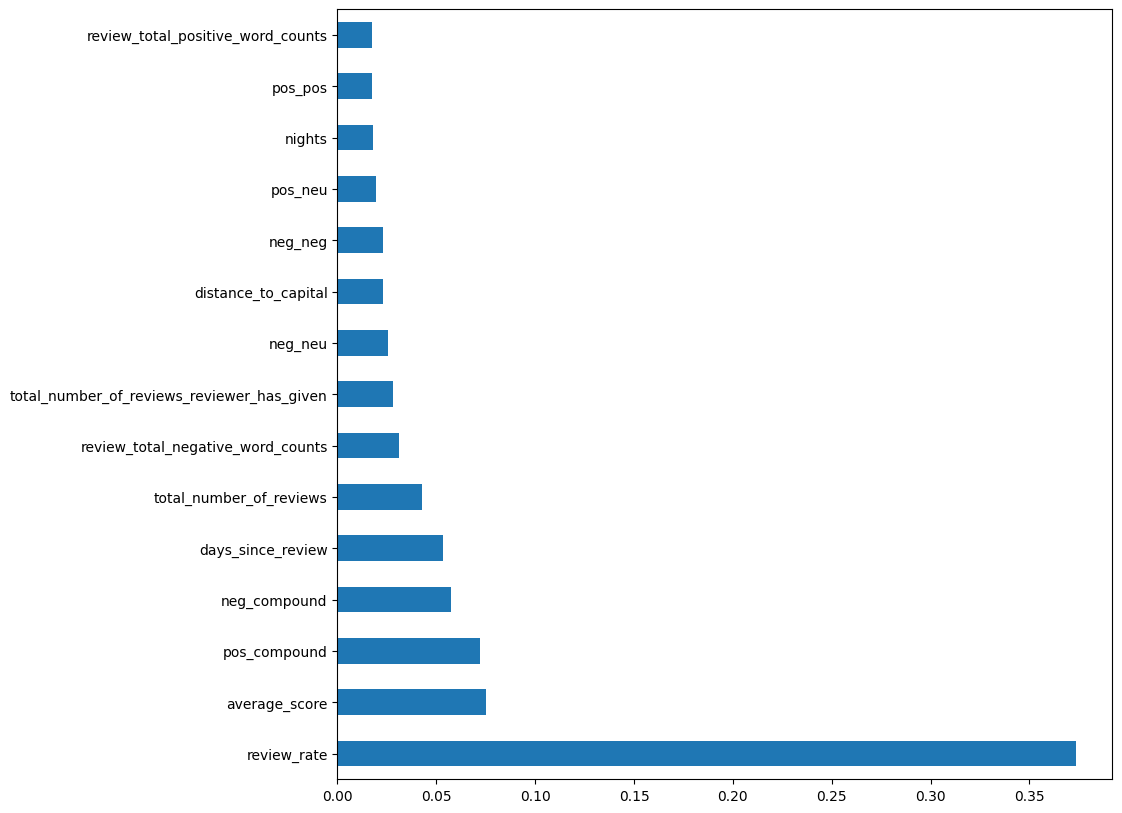

In [138]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh');

In [139]:
test_data.sample(10)

,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,population,distance_to_capital,SWL,review_rate,...,is_citizen,pos_neg,pos_neu,pos_pos,pos_compound,neg_neg,neg_neu,neg_compound,reviewer_score,is_capital
74943,8.8,54,1696,8,4,370,47.62,506.0,233.33,0.163636,...,0,0.00,0.331,0.669,0.8442,0.041,0.835,0.5423,0.0,0
48365,9.1,14,352,18,1,223,68.04,1.0,240.00,1.266667,...,0,0.00,0.648,0.352,0.7935,0.173,0.827,-0.3182,0.0,1
119913,8.0,34,3150,14,3,568,67.03,2.0,236.67,0.428571,...,0,0.00,0.619,0.381,0.7316,0.068,0.932,-0.2912,0.0,1
381,7.1,10,1877,9,1,453,67.03,6.0,236.67,0.909091,...,1,0.00,0.680,0.320,0.5095,0.000,0.722,0.4019,0.0,1
12079,8.2,0,2898,24,3,413,67.03,3.0,236.67,25.000000,...,0,0.00,0.616,0.384,0.8910,0.000,0.000,0.5574,0.0,1
49056,8.6,20,4426,5,2,100,67.03,2.0,236.67,0.285714,...,0,0.00,0.423,0.577,0.6249,0.000,0.527,0.8945,0.0,1
73940,8.6,69,3486,31,3,298,67.03,4.0,236.67,0.457143,...,1,0.00,0.850,0.150,0.5789,0.139,0.825,-0.6908,0.0,1
44544,8.9,134,3168,21,12,267,67.03,2.0,236.67,0.162963,...,0,0.00,0.725,0.275,0.6908,0.109,0.836,-0.8074,0.0,1
68287,8.5,19,1231,68,16,673,58.89,480.0,230.00,3.450000,...,0,0.02,0.726,0.254,0.9684,0.218,0.782,-0.4404,0.0,0
57177,9.3,19,1608,16,1,494,67.03,1.0,236.67,0.850000,...,1,0.00,0.517,0.483,0.8822,0.251,0.749,-0.5719,0.0,1


In [140]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [141]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [142]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.8s finished


In [143]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/submission_final_v6_encoded_tags.csv', index=False)
sample_submission


,reviewer_score,id
0,8.580,488440
1,7.149,274649
2,8.116,374688
3,9.588,404352
4,9.462,451596
...,...,...
128930,8.611,495812
128931,9.280,315577
128932,7.866,511968
128933,9.568,303386
